In [2]:
!pip install numpy matplotlib

     |████████████████████████████████| 17.1 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.4 MB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 65.4 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 959 kB 68.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 36.5 MB/s eta 0:00:01


In [27]:
import json
from math import ceil
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_FOLDER = Path.cwd() / 'work' / 'results'
SUBSETS = ['train_cnn', 'val', 'train_rnn', 'test']
FOLDS = [str(fold) for fold in range(1, 11)]


BEST_MODELS = {
    'test': [
        ('hp_pr', '29'),
        ('hp_po', '63'),
        ('hp_tf', '5'),
        ('hp_cr', '56'),
        ('hp_sh', '66'),
        ('hp_ro', '14'),
    ],
    'val': [
        ('hp_pr', '57'),
        ('hp_po', '63'),
        ('hp_tf', '69'),
        ('hp_cr', '55'),
        ('hp_sh', '72'),
        ('hp_ro', '33'),
    ]
}

def get_metrics(exp_name, model_id):
    metrics_path = RESULTS_FOLDER / exp_name / f'model_{model_id}' / 'metrics.json'
    
    with open(metrics_path, 'r') as metrics_json:
        metrics_file = json.load(metrics_json)

    return metrics_file['metrics']

def n_bins(values):
    sorted_values = sorted(values)
    length = len(sorted_values)
    q1 = ceil(length / 4)
    q3 = ceil(length * 3 / 4)
    IQR = sorted_values[q3 - 1] - sorted_values[q1 - 1]
    h = 2 * IQR * (length ** (-1/3))
    max_value = values[-1]
    min_value = values[0]
    return ceil((max_value - min_value) / h)

In [66]:
model_metrics = get_metrics('hp_po', '63')

In [14]:
model_metrics['1']['test']['33_PDNRKIBC'].keys()

dict_keys(['f1', 'rec', 'fp', 'pre', 'fn', 'acc', 'total', 'tp', 'tn', 'real', 'pred'])

In [47]:
def generate_model_f1_scores(model_type, model_id, data_set_name):
    model_metrics = get_metrics(model_type, model_id)
    f1_scores = [
        {
            'pb_name': pb_name,
            'f1': model_metrics[fold][data_set_name][pb_name]['f1'],
        }
        for fold in FOLDS
        for pb_name in model_metrics[fold][data_set_name].keys()

    ]
    f1_scores.sort(key=lambda item: item['f1'])
    return [item['f1'] for item in f1_scores]

In [67]:
f1_scores = [
    {
        'pb_name': pb_name,
        'f1': model_metrics[fold]['test'][pb_name]['f1'],
    }
    for fold in FOLDS
    for pb_name in model_metrics[fold]['test'].keys()
    
]
f1_scores.sort(key=lambda item: item['f1'])

In [17]:
def display_scores(scores):
    for score in scores:
        print(f'{score["pb_name"]} & ${score["f1"]:.2f}$ \\\\')

### Peores

In [68]:
display_scores(f1_scores[:5])

20_PD6M9KHG & $0.00$ \\
64_PDJJP4QL & $0.00$ \\
48_PDKS3P67 & $0.00$ \\
43_PDQWC1XR & $0.00$ \\
03_PDJP9L2M & $0.00$ \\


### Intermedios

In [69]:
display_scores(f1_scores[38:43])

72_PD2D493T & $0.71$ \\
47_PDGSQ7BF & $0.71$ \\
52_PDOYQKSY & $0.71$ \\
71_PD51BBXI & $0.72$ \\
26_PDILCBKV & $0.73$ \\


### Mejores

In [70]:
display_scores(f1_scores[-5:])

13_PD2SW1EO & $1.00$ \\
69_PDNVGH7Z & $1.00$ \\
65_PDY5C128 & $1.00$ \\
15_PDX94EF7 & $1.00$ \\
70_PDUPMC2M & $1.00$ \\


In [62]:
def setup_plot(axis, model, f1_scores, show_x_label, show_y_label, y_lim=37):
    axis.grid(axis='y')
    axis.set_axisbelow(True)
    if show_x_label: axis.set_xlabel('F1 Score')
    if show_y_label: axis.set_ylabel('# Pullbacks')
    axis.set_ylim(0, y_lim)
    axis.set_title(f'{model[0][-2:]}-{model[1]}'.upper())
    axis.hist(f1_scores, bins=n_bins(f1_scores))

In [42]:
def generate_all_f1_scores(model_set_name, data_set_name):
    for model in BEST_MODELS[model_set_name]:
        yield model, generate_model_f1_scores(*model, data_set_name)

In [21]:
def should_show_labels(row_index, col_index):
    if col_index == 0 and row_index == 2:
        return (True, True)
    if row_index == 2:
        return (True, False)
    if col_index == 0:
        return (False, True)
    return (False, False)

### Mejores modelos según validación. F1 sobre conjunto de Prueba

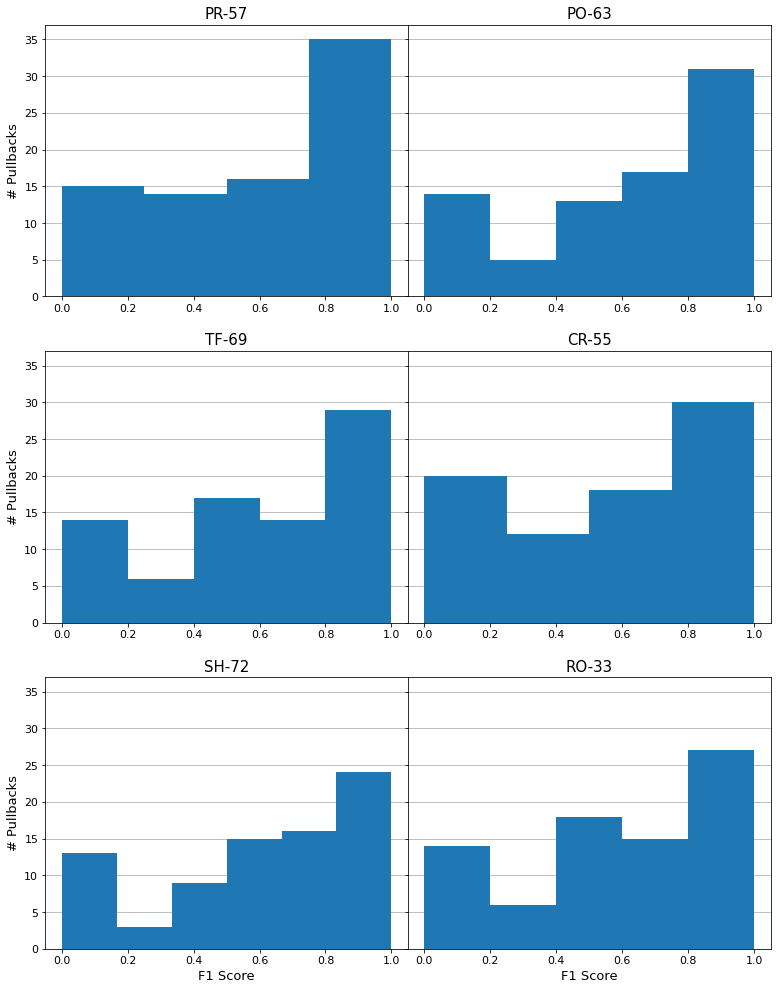

In [63]:
plt.rc('axes', labelsize=13, titlesize=15)
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(13, 17))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0)
axises = gs.subplots(sharey='row')
all_f1_scores = generate_all_f1_scores('val', 'test')

for row_index, row in enumerate(axises):
    for col_index, axis in enumerate(row):
        model, f1_scores = next(all_f1_scores)
        show_x_label, show_y_label = should_show_labels(row_index, col_index)
        setup_plot(axis, model, f1_scores, show_x_label, show_y_label)

### Histograma: Mejores modelos según validación. F1 sobre conjunto de Validación

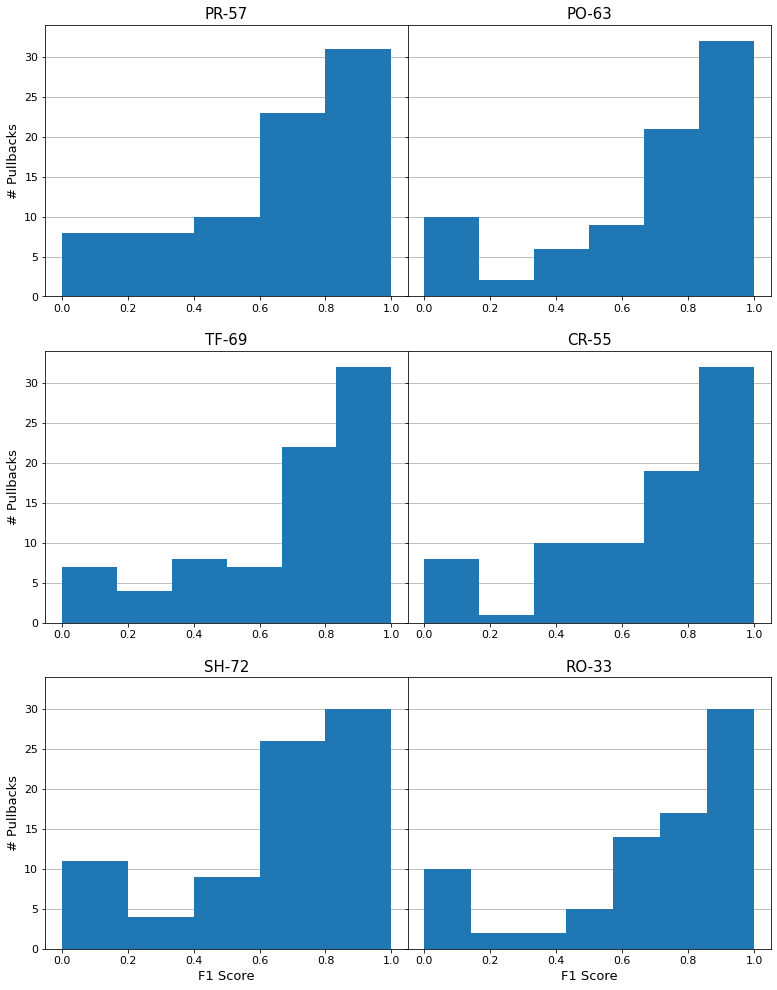

In [65]:
plt.rc('axes', labelsize=13, titlesize=15)
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11)
fig = plt.figure(figsize=(13, 17))
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0)
axises = gs.subplots(sharey='row')
all_f1_scores = generate_all_f1_scores('val', 'val')

for row_index, row in enumerate(axises):
    for col_index, axis in enumerate(row):
        model, f1_scores = next(all_f1_scores)
        show_x_label, show_y_label = should_show_labels(row_index, col_index)
        setup_plot(axis, model, f1_scores, show_x_label, show_y_label, y_lim=34)

### Boxplot: Mejores modelos según validación. F1 sobre conjunto de prueba

[None, Text(0.5, 0, 'Modelo'), Text(0, 0.5, '$\\overline{F}_1$')]

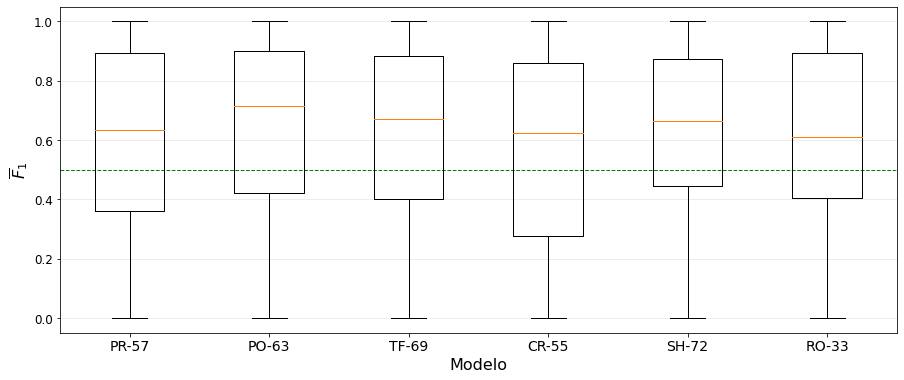

In [53]:
plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0)
axis = gs.subplots(sharey='row')

labels = [f'{model_type[-2:]}-{model_id}'.upper() for model_type, model_id in BEST_MODELS['val']]

axis.hlines(
    y=0.5,
    xmin=0.5,
    xmax=6.5,
    colors='g',
    linestyles='--',
    lw=1,
)
axis.boxplot([scores for model, scores in generate_all_f1_scores('val', 'test')], labels=labels)

axis.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axis.set(
    axisbelow=True,
    xlabel='Modelo',
    ylabel=r'$\overline{F}_1$',
)

In [32]:
def custom_exp(np_array):
    return np.exp(np_array) - 1

In [33]:
def identity(x):
    return x

In [34]:
def add_n(n):
    def f(x):
        return x + n
    return f

In [35]:
def mult_n(n):
    def f(x):
        return x * n
    return f

In [36]:
def custom_log(np_array):
    return np.log(np_array)

In [48]:
def transform_all_f1_scores(x_fun, y_fun, model_set_name, data_set_name):
    for model in BEST_MODELS[model_set_name]:
        scores = [
            x_fun(score)
            for score in generate_model_f1_scores(*model, data_set_name)
        ]
        yield model, y_fun(scores)

In [94]:
custom_exp(1)

1.718281828459045

[None,
 Text(0.5, 0, 'Modelo'),
 Text(0, 0.5, '$\\mathrm{exp}(2\\cdot \\overline{F}_1) - 1$')]

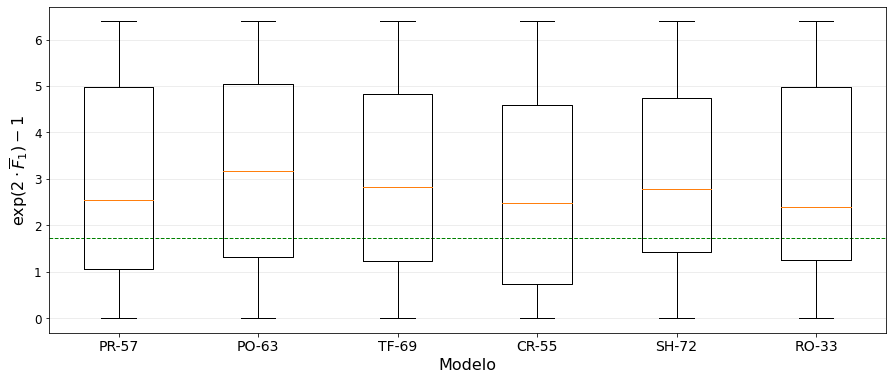

In [54]:
add_1 = add_n(1)
mult_2 = mult_n(2)

mid_point = custom_exp(mult_2(0.5))

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0)
axis = gs.subplots(sharey='row')

labels = [f'{model_type[-2:]}-{model_id}'.upper() for model_type, model_id in BEST_MODELS['val']]

axis.hlines(
    y=mid_point,
    xmin=0.5,
    xmax=6.5,
    colors='g',
    linestyles='--',
    lw=1,
)
axis.boxplot([scores for model, scores in transform_all_f1_scores(mult_2, custom_exp, 'val', 'test')], labels=labels)

axis.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axis.set(
    axisbelow=True,
    xlabel='Modelo',
    ylabel=r'$\mathrm{exp}(2\cdot \overline{F}_1) - 1$',
)

### Boxplot: Mejores modelos según validación. F1 sobre conjunto de validación

[None, Text(0.5, 0, 'Modelo'), Text(0, 0.5, '$\\overline{F}_1$')]

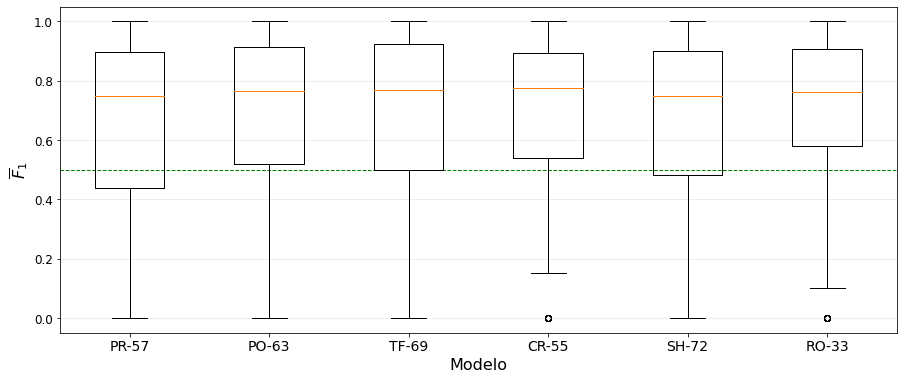

In [51]:
plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0)
axis = gs.subplots(sharey='row')

labels = [f'{model_type[-2:]}-{model_id}'.upper() for model_type, model_id in BEST_MODELS['val']]

axis.hlines(
    y=0.5,
    xmin=0.5,
    xmax=6.5,
    colors='g',
    linestyles='--',
    lw=1,
)
axis.boxplot([scores for model, scores in generate_all_f1_scores('val', 'val')], labels=labels)

axis.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axis.set(
    axisbelow=True,
    xlabel='Modelo',
    ylabel=r'$\overline{F}_1$',
)

[None,
 Text(0.5, 0, 'Modelo'),
 Text(0, 0.5, '$\\mathrm{exp}(2\\cdot \\overline{F}_1) - 1$')]

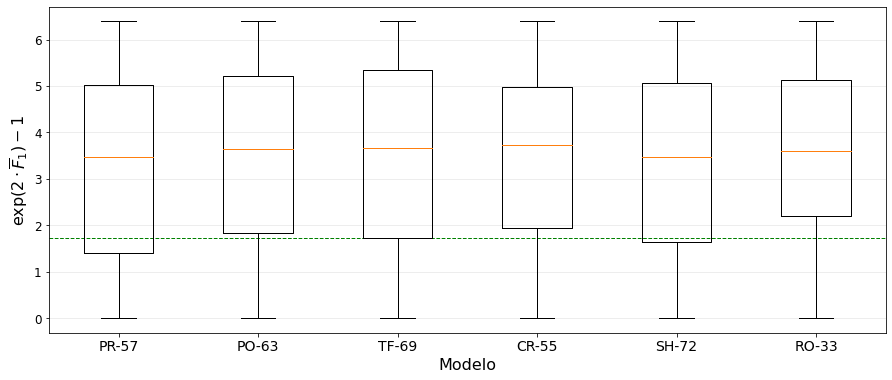

In [52]:
add_1 = add_n(1)
mult_2 = mult_n(2)

mid_point = custom_exp(mult_2(0.5))

plt.rc('axes', labelsize=16, titlesize=16)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(15,6))
gs = fig.add_gridspec(1, 1, hspace=0.2, wspace=0)
axis = gs.subplots(sharey='row')

labels = [f'{model_type[-2:]}-{model_id}'.upper() for model_type, model_id in BEST_MODELS['val']]

axis.hlines(
    y=mid_point,
    xmin=0.5,
    xmax=6.5,
    colors='g',
    linestyles='--',
    lw=1,
)
axis.boxplot([scores for model, scores in transform_all_f1_scores(mult_2, custom_exp, 'val', 'val')], labels=labels)

axis.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axis.set(
    axisbelow=True,
    xlabel='Modelo',
    ylabel=r'$\mathrm{exp}(2\cdot \overline{F}_1) - 1$',
)

In [31]:
log_1 = np.log([value + 1 for value in x_hp_pr_29])

In [32]:
exp_1 = np.exp(x_hp_pr_29)

In [82]:
exp_2 = np.exp([value for value in x_hp_pr_29]) - 1

In [119]:
exp_3 = np.exp([2 * value for value in x_hp_pr_29]) - 1

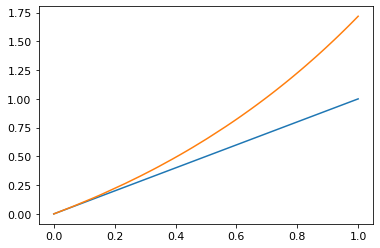

In [120]:
plt.plot(x_hp_pr_29, x_hp_pr_29)
plt.plot(x_hp_pr_29, exp_2)

plt.show()